Adapted from 13_dqn.ipynb for solving tic tac toe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set a random seed for reproducibility across runs
seed = 42
random.seed(seed)  # Seed for Python's random module
np.random.seed(seed)  # Seed for NumPy
torch.manual_seed(seed)  # Seed for PyTorch (CPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # Seed for PyTorch (GPU)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

Using device: cpu


In [2]:
class GameBoard:
    """-1 in state means empty; 0 for RL agent; 1 for opponent"""

    def __init__(self) -> None:
        self.state = self.start_state  # Current state

    @property
    def start_state(self):
        return [[-1 for _ in range(3)] for _ in range(3)]

    @classmethod
    def check_winner(cls, state: list[list[int]]) -> int:
        """Return winning player index or -1 if no winner"""
        # Check rows for a win
        for row in state:
            if row[0] == row[1] == row[2] and row[0] != -1:
                return row[0]

        # Check columns for a win
        for col in range(3):
            if state[0][col] == state[1][col] == state[2][col] and state[0][col] != -1:
                return state[0][col]

        # Check diagonals for a win
        if state[0][0] == state[1][1] == state[2][2] and state[0][0] != -1:
            return state[0][0]
        if state[0][2] == state[1][1] == state[2][0] and state[0][2] != -1:
            return state[0][2]

        return -1

    @property
    def action_space(self) -> list[tuple[int, int]]:
        return [(i, j) for i in range(3) for j in range(3)]

    def reset(self):
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state: list[list[int]]) -> torch.Tensor:
        """Flatten state and convert to tensor. Re-order be in range (0, num_players + 1)"""
        return torch.tensor(state).flatten() + 1

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        """
        Performs one step in the environment based on the given action. Opponent
        will move randomly in valid position if not ended.

        Returns:
            Tuple[torch.Tensor, float, bool]:
                - next_state_tensor (torch.Tensor): The next state as a normalized tensor.
                - reward (float): The reward for the action.
                - done (bool): Whether the episode has ended.
        """
        has_winner = self.check_winner(self.state) != -1
        action_row, action_col = self.action_space[action]
        is_invalid_move = self.state[action_row][action_col] != -1
        if has_winner or is_invalid_move:
            reward = -100.0 if is_invalid_move else 0.0
            return self._get_state_tensor(self.state), reward, True

        self.state[action_row][action_col] = 0
        if self.check_winner(self.state) == 0:
            return self._get_state_tensor(self.state), 10.0, True

        valid_actions = []
        for i in range(3):
            for j in range(3):
                if self.start_state[i][j] == -1:
                    valid_actions.append((i, j))
        opponent_action = valid_actions[0]
        self.state[opponent_action[0]][opponent_action[1]] = 1
        if self.check_winner(self.state) == 1:
            return self._get_state_tensor(self.state), -10.0, True

        return self._get_state_tensor(self.state), -1.0, False

In [3]:
# Define the Q-Network architecture
class DQN(nn.Sequential):
    """Simple MLP Q-Network"""

    def __init__(self, num_players: int, num_actions: int):
        """
        Initialize the DQN.

        Args:
            num_players (int): Number of players not including empty space
            num_actions (int): Number of possible actions.
        """
        super().__init__(
            nn.Embedding(num_players + 1, 16),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(16 * 9, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions),
        )

In [4]:
# Define the structure for storing transitions
Transition = namedtuple(
    "Transition", ("state", "action", "next_state", "reward", "done")
)


# Define the Replay Memory class
class ReplayMemory(object):
    """Stores transitions and allows sampling batches."""

    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int) -> List[Transition]:
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Return the current size of the memory."""
        return len(self.memory)

In [5]:
# Action Selection (Epsilon-Greedy - Modified for single state tensor input)
def select_action_custom(
    state_tensor: torch.Tensor,
    policy_net: nn.Module,
    epsilon_start: float,
    epsilon_end: float,
    epsilon_decay: int,
    n_actions: int,
) -> Tuple[torch.Tensor, float]:
    """
    Selects an action using the epsilon-greedy strategy for a single state tensor.

    Parameters:
    - state (torch.Tensor): The current state as a tensor of shape [state_dim].
    - policy_net (nn.Module): The Q-network used to estimate Q-values.
    - epsilon_start (float): Initial value of epsilon (exploration rate).
    - epsilon_end (float): Final value of epsilon after decay.
    - epsilon_decay (int): Decay rate for epsilon (higher value means slower decay).
    - n_actions (int): Number of possible actions.

    Returns:
    - Tuple[torch.Tensor, float]:
        - The selected action as a tensor of shape [1, 1].
        - The current epsilon value after decay.
    """
    global steps_done_custom  # Counter to track the number of steps taken
    sample = random.random()  # Generate a random number for epsilon-greedy decision
    # Compute the current epsilon value based on the decay formula
    epsilon_threshold = epsilon_end + (epsilon_start - epsilon_end) * math.exp(
        -1.0 * steps_done_custom / epsilon_decay
    )
    steps_done_custom += 1  # Increment the step counter

    if sample > epsilon_threshold:
        # Exploitation: Choose the action with the highest Q-value
        with torch.no_grad():
            # Add a batch dimension to the state tensor to make it [1, state_dim]
            state_batch = state_tensor.unsqueeze(0)
            # Get the action with the maximum Q-value (output shape: [1, n_actions])
            action = policy_net(state_batch).max(1)[1].view(1, 1)  # Reshape to [1, 1]
    else:
        # Exploration: Choose a random action
        action = torch.tensor(
            [[random.randrange(n_actions)]], device=device, dtype=torch.long
        )

    return action, epsilon_threshold

In [6]:
def optimize_model(memory: ReplayMemory,
                   policy_net: nn.Module,
                   target_net: nn.Module,
                   optimizer: optim.Optimizer,
                   batch_size: int,
                   gamma: float,
                   criterion: nn.Module = nn.SmoothL1Loss()) -> Optional[float]:
    """
    Performs one step of optimization on the policy network.

    Parameters:
    - memory (ReplayMemory): The replay memory containing past transitions.
    - policy_net (nn.Module): The main Q-network being optimized.
    - target_net (nn.Module): The target Q-network used for stable target computation.
    - optimizer (optim.Optimizer): The optimizer for updating the policy network.
    - batch_size (int): The number of transitions to sample for each optimization step.
    - gamma (float): The discount factor for future rewards.
    - criterion (nn.Module): The loss function to use (default: SmoothL1Loss).

    Returns:
    - Optional[float]: The loss value for the optimization step, or None if not enough samples.
    """
    # Ensure there are enough samples in memory to perform optimization
    if len(memory) < batch_size:
        return None

    # Sample a batch of transitions from replay memory
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))  # Unpack transitions into separate components

    # Identify non-final states (states that are not terminal)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device, dtype=torch.bool)

    # Stack non-final next states into a tensor
    if any(non_final_mask):  # Check if there are any non-final states
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    # Stack current states, actions, rewards, and dones into tensors
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    done_batch = torch.cat(batch.done)

    # Compute Q(s_t, a) for the actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for the next states using the target network
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        if any(non_final_mask):  # Only compute for non-final states
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values using the Bellman equation
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute the loss between predicted and expected Q values
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Perform backpropagation and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Compute gradients
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)  # Clip gradients to prevent explosion
    optimizer.step()  # Update the policy network

    return loss.item()  # Return the loss value for logging

In [7]:
def update_target_net(policy_net: nn.Module, target_net: nn.Module) -> None:
    """
    Copies the weights from the policy network to the target network.

    Parameters:
    - policy_net (nn.Module): The main Q-network whose weights are to be copied.
    - target_net (nn.Module): The target Q-network to which weights are copied.

    Returns:
    - None
    """
    target_net.load_state_dict(policy_net.state_dict())

In [8]:
# Hyperparameters for Custom Grid World
BATCH_SIZE_CUSTOM = 128
GAMMA_CUSTOM = 0.99         # Discount factor (encourage looking ahead)
EPS_START_CUSTOM = 1.0      # Start with full exploration
EPS_END_CUSTOM = 0.05       # End with 5% exploration
EPS_DECAY_CUSTOM = 10000    # Slower decay for potentially larger state space exploration needs
TAU_CUSTOM = 0.005          # Tau for soft updates (alternative, not used here)
LR_CUSTOM = 2e-4            # Learning rate (might need tuning)
MEMORY_CAPACITY_CUSTOM = 10000
TARGET_UPDATE_FREQ_CUSTOM = 20 # Update target net less frequently maybe
NUM_EPISODES_CUSTOM = 5000      # More episodes might be needed
MAX_STEPS_PER_EPISODE_CUSTOM = 200 # Max steps per episode (grid size related)

In [9]:
custom_env = GameBoard()

n_actions_custom: int = len(custom_env.action_space)
num_players: int = 2

# Initialize the policy network (main Q-network) and target network
policy_net_custom: DQN = DQN(num_players, n_actions_custom).to(device)
target_net_custom: DQN = DQN(num_players, n_actions_custom).to(device)

# Copy the weights from the policy network to the target network and set it to evaluation mode
target_net_custom.load_state_dict(policy_net_custom.state_dict())  # Synchronize weights
target_net_custom.eval()  # Set target network to evaluation mode

# Initialize the optimizer for the policy network
optimizer_custom: optim.AdamW = optim.AdamW(
    policy_net_custom.parameters(), lr=LR_CUSTOM, amsgrad=True
)

# Initialize the replay memory with the specified capacity
memory_custom: ReplayMemory = ReplayMemory(MEMORY_CAPACITY_CUSTOM)

# Lists for plotting
episode_rewards_custom = []
episode_lengths_custom = []
episode_epsilons_custom = []
episode_losses_custom = []

In [10]:
print("Starting DQN Training on Custom Grid World...")

# Initialize the global counter for epsilon decay
steps_done_custom = 0

# Training Loop
for i_episode in range(NUM_EPISODES_CUSTOM):
    # Reset the environment and get the initial state tensor
    state_tensor = custom_env.reset()
    total_reward = 0
    current_losses = []

    for t in range(MAX_STEPS_PER_EPISODE_CUSTOM):
        # Select an action using epsilon-greedy policy
        action_tensor, current_epsilon = select_action_custom(
            state_tensor,
            policy_net_custom,
            EPS_START_CUSTOM,
            EPS_END_CUSTOM,
            EPS_DECAY_CUSTOM,
            n_actions_custom,
        )
        action = action_tensor.item()

        # Take a step in the environment
        next_state_tensor, reward, done = custom_env.step(action)
        total_reward += reward

        # Prepare tensors for storing in replay memory
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)
        action_tensor_mem = torch.tensor([[action]], device=device, dtype=torch.long)
        done_tensor = torch.tensor([done], device=device, dtype=torch.bool)

        # Store the transition in replay memory
        memory_next_state = next_state_tensor if not done else None
        memory_custom.push(
            state_tensor,
            action_tensor_mem,
            memory_next_state,
            reward_tensor,
            done_tensor,
        )

        # Move to the next state
        state_tensor = next_state_tensor

        # Perform one optimization step on the policy network
        loss = optimize_model(
            memory_custom,
            policy_net_custom,
            target_net_custom,
            optimizer_custom,
            BATCH_SIZE_CUSTOM,
            GAMMA_CUSTOM,
        )
        if loss is not None:
            current_losses.append(loss)

        # Break the loop if the episode is done
        if done:
            break

    # Store episode statistics
    episode_rewards_custom.append(total_reward)
    episode_lengths_custom.append(t + 1)
    episode_epsilons_custom.append(current_epsilon)
    episode_losses_custom.append(np.mean(current_losses) if current_losses else 0)

    # Update the target network periodically
    if i_episode % TARGET_UPDATE_FREQ_CUSTOM == 0:
        update_target_net(policy_net_custom, target_net_custom)

    # Print progress every 50 episodes
    if (i_episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards_custom[-50:])
        avg_length = np.mean(episode_lengths_custom[-50:])
        avg_loss = np.mean([l for l in episode_losses_custom[-50:] if l > 0])
        print(
            f"Episode {i_episode+1}/{NUM_EPISODES_CUSTOM} | "
            f"Avg Reward (last 50): {avg_reward:.2f} | "
            f"Avg Length: {avg_length:.2f} | "
            f"Avg Loss: {avg_loss:.4f} | "
            f"Epsilon: {current_epsilon:.3f}"
        )

print("Custom Grid World Training Finished.")

Starting DQN Training on Custom Grid World...
Episode 50/5000 | Avg Reward (last 50): -89.52 | Avg Length: 3.72 | Avg Loss: 22.5310 | Epsilon: 0.983
Episode 100/5000 | Avg Reward (last 50): -80.48 | Avg Length: 3.48 | Avg Loss: 22.7469 | Epsilon: 0.966
Episode 150/5000 | Avg Reward (last 50): -91.28 | Avg Length: 3.28 | Avg Loss: 21.5406 | Epsilon: 0.952
Episode 200/5000 | Avg Reward (last 50): -69.42 | Avg Length: 3.42 | Avg Loss: 18.3944 | Epsilon: 0.936
Episode 250/5000 | Avg Reward (last 50): -82.44 | Avg Length: 3.24 | Avg Loss: 16.0327 | Epsilon: 0.922
Episode 300/5000 | Avg Reward (last 50): -78.32 | Avg Length: 3.52 | Avg Loss: 15.3377 | Epsilon: 0.907
Episode 350/5000 | Avg Reward (last 50): -69.66 | Avg Length: 3.66 | Avg Loss: 15.1291 | Epsilon: 0.891
Episode 400/5000 | Avg Reward (last 50): -67.54 | Avg Length: 3.74 | Avg Loss: 14.9539 | Epsilon: 0.876
Episode 450/5000 | Avg Reward (last 50): -78.18 | Avg Length: 3.38 | Avg Loss: 14.8912 | Epsilon: 0.862
Episode 500/5000 | 

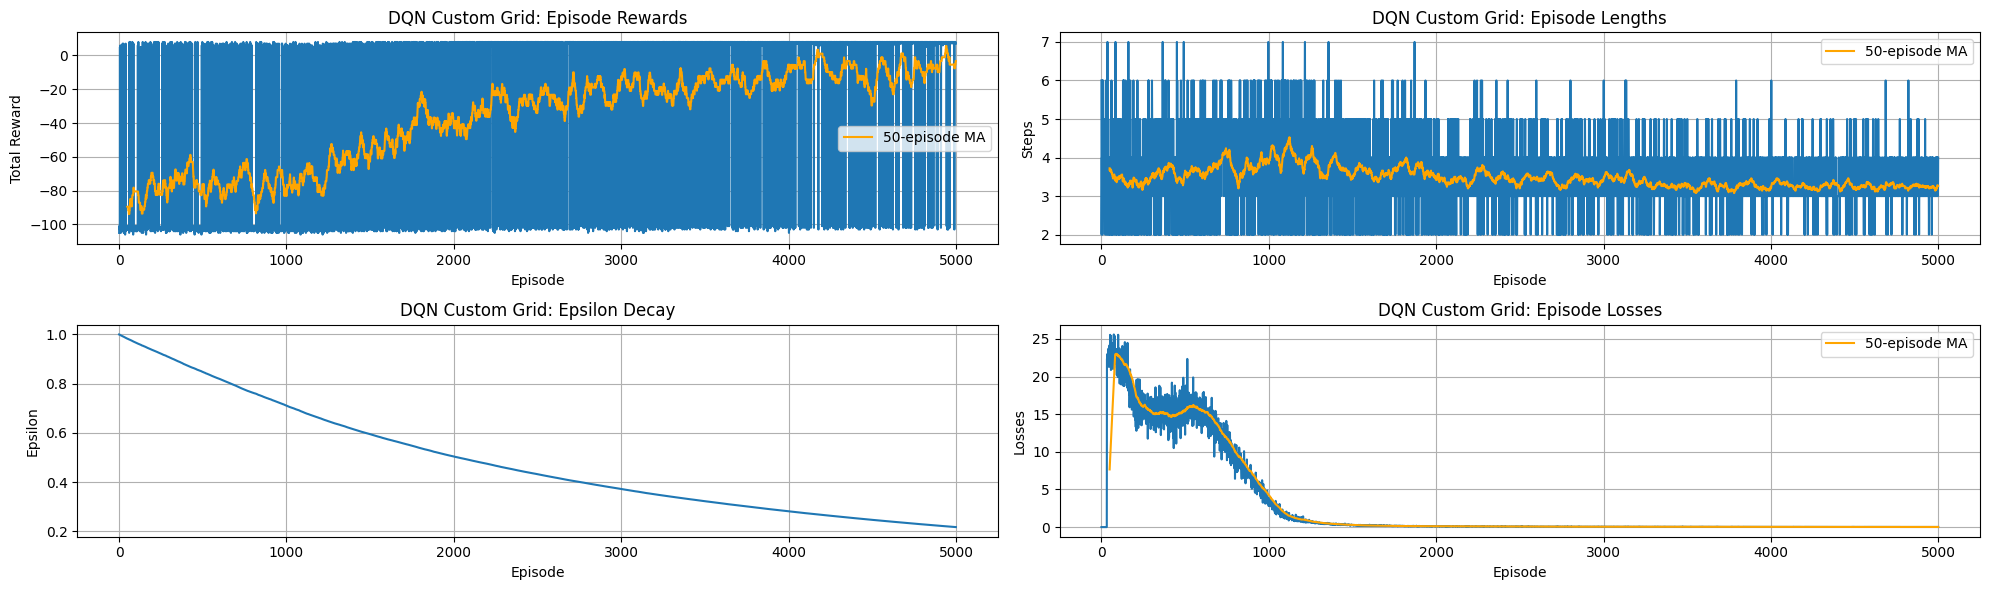

In [11]:
# Plotting results for Custom Grid World
plt.figure(figsize=(20, 6))

# Rewards
plt.subplot(2, 2, 1)
plt.plot(episode_rewards_custom)
plt.title('DQN Custom Grid: Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
rewards_ma_custom = np.convolve(episode_rewards_custom, np.ones(50)/50, mode='valid')
if len(rewards_ma_custom) > 0: # Avoid plotting empty MA
    plt.plot(np.arange(len(rewards_ma_custom)) + 49, rewards_ma_custom, label='50-episode MA', color='orange')
plt.legend()


# Lengths
plt.subplot(2, 2, 2)
plt.plot(episode_lengths_custom)
plt.title('DQN Custom Grid: Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
lengths_ma_custom = np.convolve(episode_lengths_custom, np.ones(50)/50, mode='valid')
if len(lengths_ma_custom) > 0:
    plt.plot(np.arange(len(lengths_ma_custom)) + 49, lengths_ma_custom, label='50-episode MA', color='orange')
plt.legend()

# Epsilon
plt.subplot(2, 2, 3)
plt.plot(episode_epsilons_custom)
plt.title('DQN Custom Grid: Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(episode_losses_custom)
plt.title('DQN Custom Grid: Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Losses')
plt.grid(True)
losses_ma_custom = np.convolve(episode_losses_custom, np.ones(50)/50, mode='valid')
if len(losses_ma_custom) > 0:
    plt.plot(np.arange(len(losses_ma_custom)) + 49, losses_ma_custom, label='50-episode MA', color='orange')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
game_env = GameBoard()
select_action_custom(
    game_env._get_state_tensor(game_env.state), policy_net_custom, 0, 0, 1, 9
)

(tensor([[7]]), 0.0)